### 시맨틱 세그멘테이션으로 도로영역 찾기
---
![시맨틱](https://aiffelstaticprd.blob.core.windows.net/media/original_images/result.gif)

### 1. 시맨틱 세그멘테이션 데이터셋
#### 이미지, 데이터 가져오기
- mkdir -p ~/aiffel/semantic_segmentation/data
- wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
- unzip data_semantics.zip -d ~/aiffel/semantic_segmentation/data

![시맨틱](https://aiffelstaticprd.blob.core.windows.net/media/images/000002_10_label.max-800x600.png)
![시맨틱2](https://aiffelstaticprd.blob.core.windows.net/media/images/000002_10_mqPgQu0.max-800x600.png)

#### 데이터 로더(data loader) 만들기
- pip install albumentations
  
- 참고자료
  - [Keras Sequence에 기반한 Dataloader](https://hwiyong.tistory.com/241)
  - [Albumentation을 적용한 Keras sequence](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

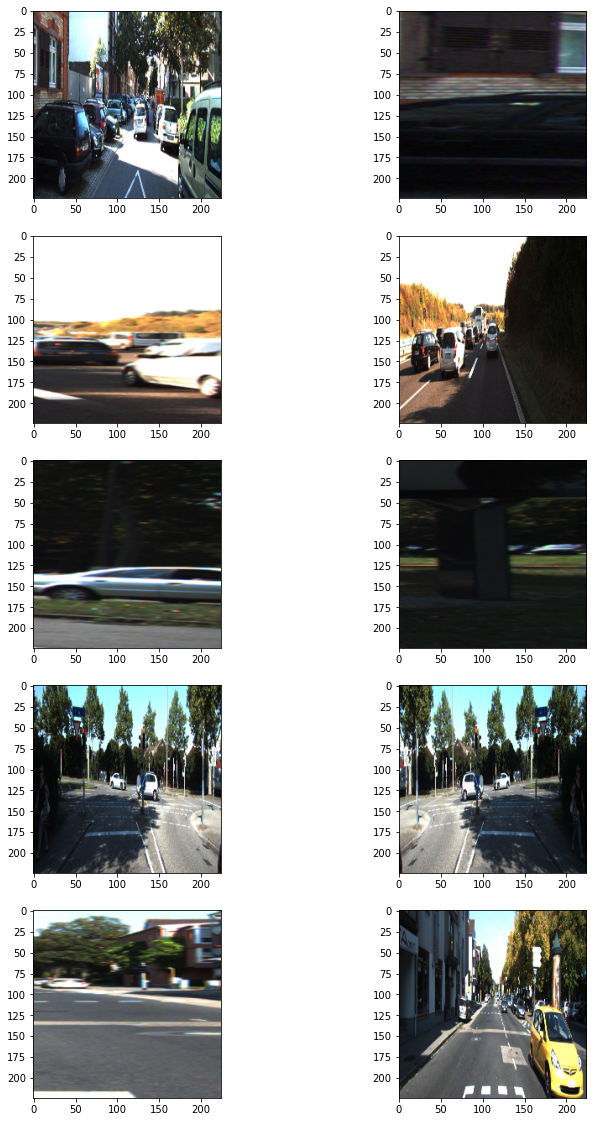

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### 시맨틱 세그멘테이션 모델
![유넷](https://aiffelstaticprd.blob.core.windows.net/media/images/u-net_1kfpgqE.max-800x600.png)
#### 모델 구조 만들기

In [6]:
def unet(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

    #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

#### 모델 학습하기

In [ ]:
unet = build_model()
unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

In [7]:
model_path = dir_path + '/unet.h5'
#unet.save(model_path)  #학습한 모델을 저장해 주세요.

### 시맨틱 세그멘테이션 모델 시각화
- model = tf.keras.models.load_model(model_path) 저장된 모델 불러오기

In [8]:
unet = tf.keras.models.load_model(model_path)

In [9]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [10]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [11]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [45]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2   # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.622965


0.6229652927219556

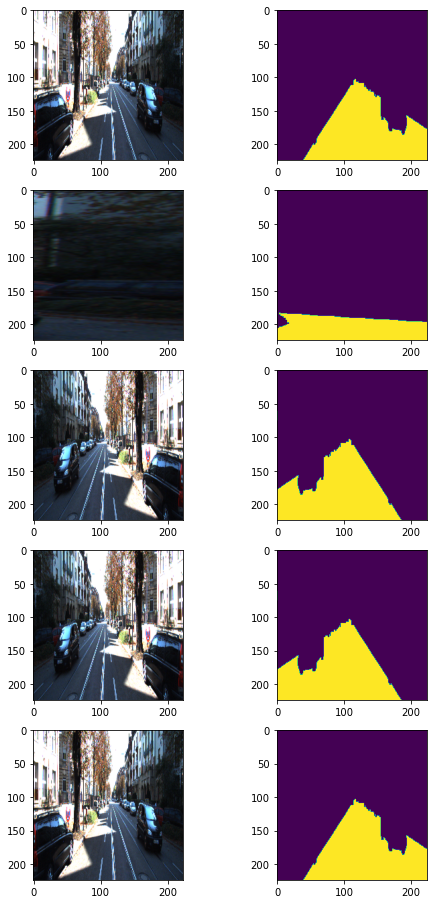

In [13]:
plt.figure(figsize=(8, 16))
for i in range(5) :
    data = next(iter(train_generator))
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(data[0][0, :, :])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(data[1][0, :, :])
plt.show()

### 프로젝트 : 개선된 U-Net 모델 만들기
-[U-Net ++](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)  
![유넷플](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-5-P-UNPP.max-800x600.png)  

In [27]:
def build_UNet_Plus(input_shape=(224, 224, 3), n = 16) :
    
    filters = [n, n*2, n*4, n*8, n*16]
    
    inputs = Input(input_shape)
    
    #conv0_0
    conv001 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn001 = BatchNormalization()(conv001)
    act001 = Activation('relu')(bn001)
    conv002 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act001)
    bn002 = BatchNormalization()(conv002)
    conv00 = Activation('relu')(bn002)
    
    #conv1_0
    conv00_down = MaxPooling2D(strides=2)(conv00)
    conv101 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv00_down)
    bn101 = BatchNormalization()(conv101)
    act101 = Activation('relu')(bn101)
    conv102 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act101)
    bn102 = BatchNormalization()(conv102)
    conv10 = Activation('relu')(bn102)
    
    #conv2_0
    conv10_down = MaxPooling2D(strides=2)(conv10)
    conv201 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv10_down)
    bn201 = BatchNormalization()(conv201)
    act201 = Activation('relu')(bn201)
    conv202 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act201)
    bn202 = BatchNormalization()(conv202)
    conv20 = Activation('relu')(bn202)
    
    #conv3_0
    conv20_down = MaxPooling2D(strides=2)(conv20)
    conv301 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv20_down)
    bn301 = BatchNormalization()(conv301)
    act301 = Activation('relu')(bn301)
    conv302 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act301)
    bn302 = BatchNormalization()(conv302)
    conv30 = Activation('relu')(bn302)
    
    #conv4_0
    conv30_down = MaxPooling2D(strides=2)(conv30)
    conv401 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv30_down)
    bn401 = BatchNormalization()(conv401)
    act401 = Activation('relu')(bn401)
    conv402 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act401)
    bn402 = BatchNormalization()(conv402)
    conv40 = Activation('relu')(bn402)
    
    
    
    #conv0_1
    conv10_up = UpSampling2D()(conv10)
    conv01_in = Concatenate()([conv00, conv10_up])
    
    conv011 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv01_in)
    bn011 = BatchNormalization()(conv011)
    act011 = Activation('relu')(bn011)
    conv012 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act011)
    bn012 = BatchNormalization()(conv012)
    conv01 = Activation('relu')(bn012)
    
    #conv1_1
    conv20_up = UpSampling2D()(conv20)
    conv11_in = Concatenate()([conv10, conv20_up])
    
    conv111 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv11_in)
    bn111 = BatchNormalization()(conv111)
    act111 = Activation('relu')(bn111)
    conv112 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act111)
    bn112 = BatchNormalization()(conv112)
    conv11 = Activation('relu')(bn112)
    
    #conv2_1
    conv30_up = UpSampling2D()(conv30)
    conv21_in = Concatenate()([conv20, conv30_up])
    
    conv211 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv21_in)
    bn211 = BatchNormalization()(conv211)
    act211 = Activation('relu')(bn211)
    conv212 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act211)
    bn212 = BatchNormalization()(conv212)
    conv21 = Activation('relu')(bn212)
    
    #conv3_1
    conv40_up = UpSampling2D()(conv40)
    conv31_in = Concatenate()([conv30, conv40_up])
    
    conv311 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv31_in)
    bn311 = BatchNormalization()(conv311)
    act311 = Activation('relu')(bn311)
    conv312 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act311)
    bn312 = BatchNormalization()(conv312)
    conv31 = Activation('relu')(bn312)
    
    
    
    #conv0_2
    conv11_up = UpSampling2D()(conv11)
    conv02_in = Concatenate()([conv00, conv01, conv11_up])
    
    conv021 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv02_in)
    bn021 = BatchNormalization()(conv021)
    act021 = Activation('relu')(bn021)
    conv022 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act021)
    bn022 = BatchNormalization()(conv022)
    conv02 = Activation('relu')(bn022)
    
    #conv1_2
    conv21_up = UpSampling2D()(conv21)
    conv12_in = Concatenate()([conv10, conv11, conv21_up])
    
    conv121 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv12_in)
    bn121 = BatchNormalization()(conv121)
    act121 = Activation('relu')(bn121)
    conv122 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act121)
    bn122 = BatchNormalization()(conv122)
    conv12 = Activation('relu')(bn122)
    
    #conv2_2
    conv31_up = UpSampling2D()(conv31)
    conv22_in = Concatenate()([conv20, conv21, conv31_up])
    
    conv221 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv22_in)
    bn221 = BatchNormalization()(conv221)
    act221 = Activation('relu')(bn221)
    conv222 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act221)
    bn222 = BatchNormalization()(conv222)
    conv22 = Activation('relu')(bn222)
    
    
    
    #conv0_3
    conv12_up = UpSampling2D()(conv12)
    conv03_in = Concatenate()([conv00, conv01, conv02, conv12_up])
    
    conv031 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv03_in)
    bn031 = BatchNormalization()(conv031)
    act031 = Activation('relu')(bn031)
    conv032 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act031)
    bn032 = BatchNormalization()(conv032)
    conv03 = Activation('relu')(bn032)
    
    #conv1_3
    conv22_up = UpSampling2D()(conv22)
    conv13_in = Concatenate()([conv10, conv11, conv12, conv22_up])
    
    conv131 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv13_in)
    bn131 = BatchNormalization()(conv131)
    act131 = Activation('relu')(bn131)
    conv132 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act131)
    bn132 = BatchNormalization()(conv132)
    conv13 = Activation('relu')(bn132)
    
    
    
    #conv0_4
    conv13_up = UpSampling2D()(conv13)
    conv04_in = Concatenate()([conv00, conv01, conv02, conv03, conv13_up])
    
    conv041 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv04_in)
    bn041 = BatchNormalization()(conv041)
    act041 = Activation('relu')(bn041)
    conv042 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act041)
    bn042 = BatchNormalization()(conv042)
    conv04 = Activation('relu')(bn042)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv04)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [28]:
unet_pp = build_UNet_Plus()
unet_pp.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 224, 224, 16) 64          conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 224, 224, 16) 0           batch_normalization_60[0][0]     
_______________________________________________________________________________________

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [30]:
unet_pp.compile(
    optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy')

unet_pp.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

model_path = dir_path + '/unet_pp.h5'
unet_pp.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 3s 307ms/step - loss: 0.5503 - val_loss: 0.6677
Epoch 2/100
11/11 [==============================] - 3s 276ms/step - loss: 0.4594 - val_loss: 0.6182
Epoch 3/100
11/11 [==============================] - 3s 298ms/step - loss: 0.3954 - val_loss: 0.5686
Epoch 4/100
11/11 [==============================] - 3s 303ms/step - loss: 0.3503 - val_loss: 0.5203
Epoch 5/100
11/11 [==============================] - 3s 308ms/step - loss: 0.3402 - val_loss: 0.4828
Epoch 6/100
11/11 [==============================] - 3s 287ms/step - loss: 0.3191 - val_loss: 0.4569
Epoch 7/100
11/11 [==============================] - 3s 285ms/step - loss: 0.2980 - val_loss: 0.4325
Epoch 8/100
11/11 [==============================] - 3s 282ms/step - loss: 0.2806 - val_loss: 0.4140
Epoch 9/100
11/11 [==============================] - 3s 280ms/step - loss: 0.2853 - val_loss: 0.3961
Epoch 10/100
11/11 [==============================] - 3s 278ms/step - loss: 0.2731 - val_lo

11/11 [==============================] - 3s 280ms/step - loss: 0.1219 - val_loss: 0.1176
Epoch 80/100
11/11 [==============================] - 3s 280ms/step - loss: 0.1208 - val_loss: 0.1223
Epoch 81/100
11/11 [==============================] - 3s 280ms/step - loss: 0.1176 - val_loss: 0.1163
Epoch 82/100
11/11 [==============================] - 3s 280ms/step - loss: 0.1191 - val_loss: 0.1120
Epoch 83/100
11/11 [==============================] - 3s 279ms/step - loss: 0.1195 - val_loss: 0.1099
Epoch 84/100
11/11 [==============================] - 3s 280ms/step - loss: 0.1154 - val_loss: 0.1239
Epoch 85/100
11/11 [==============================] - 3s 279ms/step - loss: 0.1139 - val_loss: 0.1157
Epoch 86/100
11/11 [==============================] - 3s 279ms/step - loss: 0.1127 - val_loss: 0.1090
Epoch 87/100
11/11 [==============================] - 3s 280ms/step - loss: 0.1109 - val_loss: 0.1128
Epoch 88/100
11/11 [==============================] - 3s 279ms/step - loss: 0.1077 - val_loss: 

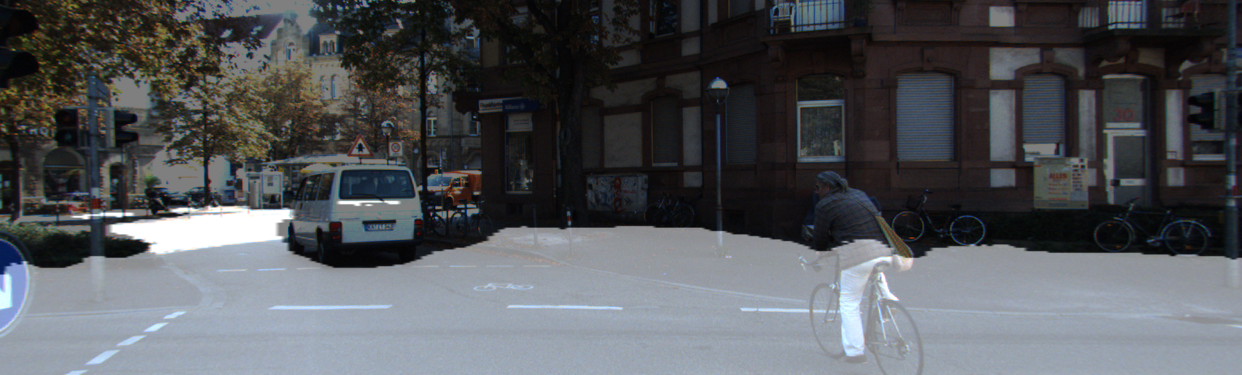

In [40]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )


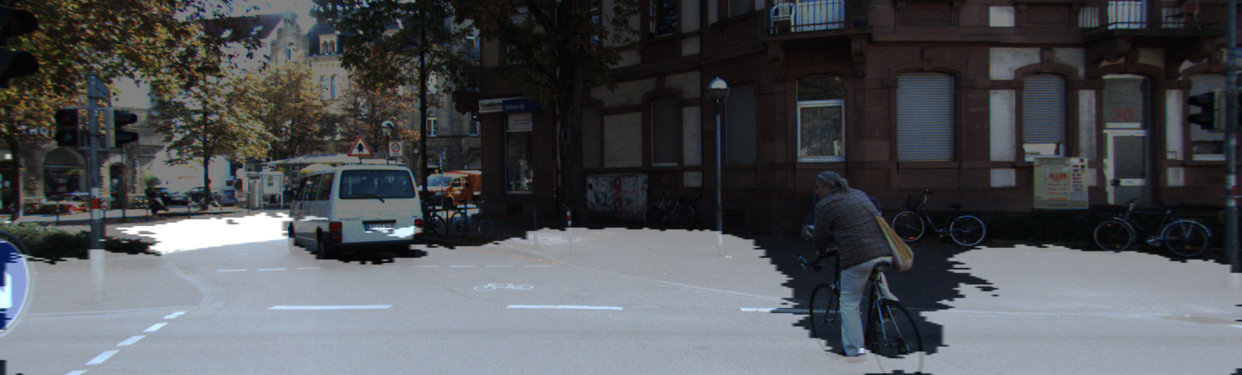

In [41]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2   # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [42]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [43]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [44]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2   # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.674780


0.674779843444227

### 정리
- 시각화로 보았을때 U-Net은 자전거를 인식하지못하고 도로로 인식한 반면, U-Net++는 자전거를 인식한 모습을 볼 수 있습니다.
- IoU 수치로 비교해보았을 땐, 1번 파일비교시 U-Net++가 0.12, 2번파일 비교시 0.05정도 성능이 좋아짐을 확인할 수 있었습니다. 